Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [2]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [52]:
from datetime import datetime, timedelta
import joblib
from data import ImplicitData
import pandas as pd 
import numpy as np 
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from plot_utils import plot_n_users_per_bucket, plot_bucket_size
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [4]:
n_iter_bucket = 50E3

In [5]:
def get_bucket_map(eval_object:EvaluateAndStore):
    '''
    Create a dict that maps users (external id) to the buckets they are in (from 1 to last).
    '''
    user_bucket_map = {user:[] for user in eval_object.data.userset}
    for user in eval_object.data.userset:
        for i, bucket in enumerate( eval_object.holdouts ):
            if user in bucket.userset:
                user_bucket_map[user].append(i+1)
    return user_bucket_map

def median_user_presence_per_bucket(eval_object:EvaluateAndStore, user_bucket_map:dict):
    '''
    On median terms, on how many buckets a user is.
    '''
    presence_list = [len(user_bucket_map[user]) for user in eval_object.data.userset]
    return np.median( presence_list )

def plot_bucket_size(eval_object, dataset_name, filename=None):
    bucket_size = pd.Series( [bucket.size for bucket in eval_object.holdouts] )
    bucket_size = bucket_size.reset_index()
    bucket_size.columns = ['Bucket', 'Size']
    bucket_size['Bucket'] = bucket_size['Bucket']+1
    plt.figure(figsize=(10,5))
    sns.barplot(x='Bucket', y='Size', data=bucket_size, color='b')
    # sns.lineplot(data=np.repeat(n_users, n_users_bucket.shape[0]), label='total users', color='orange')
    plt.title(f'Bucket size - {dataset_name}')
    if filename:
        plt.savefig(f'images/user_bucket_analysis/{filename}')

def store_user_presence(dataset_name, median_user_presence):
    with open('output/joblib_bucket_info_dump/median_user_presence.txt', 'a') as file:
        file.write(f'{dataset_name}: in median terms, users are present in {median_user_presence} bucket\n')

def plot_interactions_per_month(data, dataset_name):
    interactions_per_month = data.groupby(by=['date']).count().iloc[:, 0]
    interactions_per_month.name = 'count'
    interactions_per_month=interactions_per_month.reset_index()
    fig, ax = plt.subplots(figsize=(6,10))
    fig = sns.barplot(x='count', y='date', data=interactions_per_month, color='blue', ax=ax )
    ax.set_yticklabels(labels=list( interactions_per_month['date'].dt.year.astype(str) +'-'+ interactions_per_month['date'].dt.month.astype(str) ))
    plt.title(f'{dataset_name}: Interactions per year-month')
    plt.savefig(f'images/user_bucket_analysis/{dataset_name}_interactions_year_month.png')

def plot_user_presence_distribution(user_presence_df, dataset_name):
    fig, ax = plt.subplots(1,3, figsize=(17,4))
    user_presence_df['month_%'].plot(kind='hist', ax=ax[0], title='user month presence')
    user_presence_df['trimestre_%'].plot(kind='hist', ax=ax[1], title='user quarter presence')
    user_presence_df['semestre_%'].plot(kind='hist', ax=ax[2], title='user semester presence')
    plt.suptitle(f'{dataset_name}: User presence distribution')
    plt.savefig(f'images/user_bucket_analysis/{dataset_name}_user_presence_distribution.png');

# Store buckets

___
### Palco 2010

In [5]:
# importa dataset 'palco playlists'
data = pd.read_csv("../datasets/palco_2010.tsv","\t")

In [6]:
num_factors = 200
num_iter = 6
learn_rate = 0.35
regularization = 0.5
num_nodes = 8

In [7]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
# stream = ImplicitData(data['UserID'].to_list(), data['ItemID'].to_list())
stream = ImplicitData(data['user_id'], data['track_id'])

empty_stream = ImplicitData([], [])

In [8]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [9]:
# criamos instancia de EvaluateAndStore para criar holdouts com o método EvaluateAndStore
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_palco = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics=["Recall@N"], N_recommendations=20, seed=42)

In [10]:
# interações de 0 a 100 são usadas para pre treino. 
# count define numero de interações a serem usadas.
# holdouts e checkpoints são 
# store_only - somente guarda holdouts, não faz avaliação prequencial.
# default_user - Somente usado quando store_only = False durante avaliação prequencial.
_ = eval_palco.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 17 min

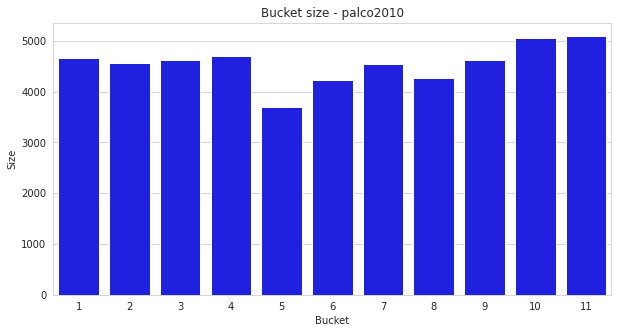

In [19]:
plot_bucket_size(eval_object=eval_palco, dataset_name='palco2010', filename='palco2010_bucket_size.png')

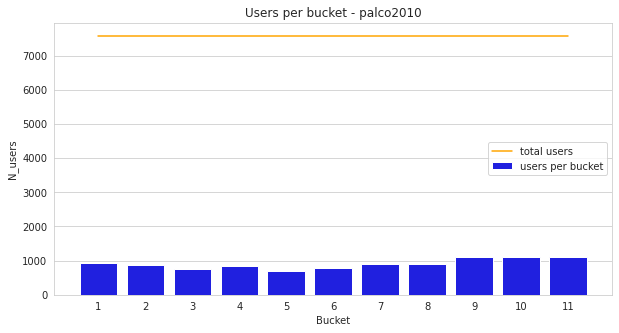

In [14]:
plot_n_users_per_bucket(eval_object=eval_palco, dataset_name='palco2010', filename='palco2010_user_per_bucket.png')

In [53]:
palco2010_ubm = get_bucket_map(eval_object=eval_palco)
palco2010_median_user_presence = median_user_presence_per_bucket(eval_object=eval_palco, user_bucket_map=palco2010_ubm)
print( palco2010_median_user_presence )
store_user_presence(dataset_name='palco2010',median_user_presence=palco2010_median_user_presence)

NameError: name 'eval_palco' is not defined

In [ ]:
joblib.dump(palco2010_ubm, 'output/joblib_bucket_info_dump/palco2010_ubm', compress=True)

['output/joblib_eval_objects_dump/palco2010_ubm']

___
### Movielens

In [6]:
# importa dataset 'movielensm1'
data = pd.read_csv("../datasets/ml1m_gte5.csv","\t")
data['date'] = data['Timestamp'].apply(lambda x: datetime.fromtimestamp( x ).date() )
data['year'] = data['Timestamp'].apply(lambda x: datetime.fromtimestamp( x ).year)
data['month'] = data['Timestamp'].apply(lambda x: datetime.fromtimestamp( x ).month )
data['date'] = data[['year', 'month']].apply(lambda x: datetime.strptime( str(x[0])+'/'+str(x[1]), '%Y/%m' ) , axis=1)

How many interactions occur in each month?

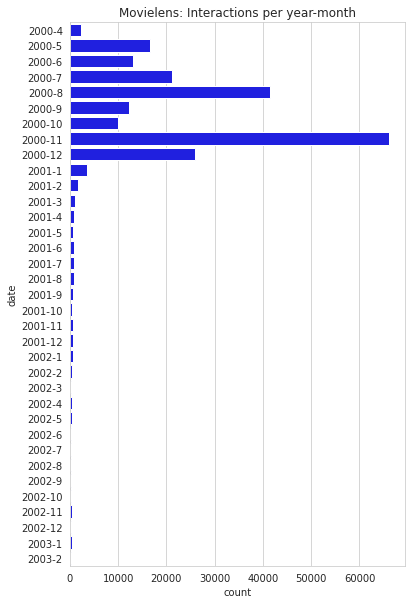

In [7]:
plot_interactions_per_month(data=data, dataset_name='Movielens')

What is the user presence distribution based on month, quarter, and semester?

In [8]:
#counting user interactions per month
user_month_interactions = data.groupby(by=['UserID', 'date']).count().iloc[:, 0]
user_month_interactions.name = 'count'
user_month_interactions = user_month_interactions.reset_index()
user_month_interactions.sort_values(by=['date'], ascending=[True], inplace=True)

In [9]:
# defining quarter and semester intervals in dataset

# https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases
# https://stackoverflow.com/questions/69714505/how-can-generate-trimester-dates-in-python

from pandas import Timestamp, date_range
from pandas.tseries.offsets import MonthBegin, MonthEnd

start_ts, end_ts = Timestamp(user_month_interactions['date'].unique()[0]), Timestamp(user_month_interactions['date'].unique()[-1])
starts = date_range(start_ts, end_ts - MonthEnd(3), freq='3M') + MonthBegin(-1)
# starts = date_range(start_ts, end_ts, freq='3M') + MonthBegin(-1)
ends = date_range(start_ts + MonthEnd(3), end_ts, freq='3M')
trimestres = list(zip(starts, ends))

starts = date_range(start_ts, end_ts - MonthEnd(6), freq='6M') + MonthBegin(-1)
ends = date_range(start_ts + MonthEnd(6), end_ts, freq='6M')
semestres = list(zip(starts, ends))

In [66]:
# verifying user presence in months, quarter, and semester
user_presence_percentage = []
user_presence_map = dict()
user_trimestre_interactions = dict()
user_semestre_interactions = dict()
for u in user_month_interactions['UserID'].unique():
    uidx = user_month_interactions['UserID'] == u
    month_presence = user_month_interactions.loc[uidx, 'date'].nunique() / user_month_interactions['date'].nunique()
    
    trimestre_presence = np.repeat(False, len(trimestres)+1 )
    semestre_presence = np.repeat(False, len(semestres)+1 )

    trimestre_count = np.zeros( len( trimestres )+1 )
    semestre_count = np.zeros( len( semestres )+1 )

    # for udt in user_month_interactions.loc[uidx, 'date'].unique():
    for udt in user_month_interactions.loc[uidx, 'date']:

        idx = np.where( [ t[0]<=Timestamp( udt )<=t[1] for t in trimestres ] + [Timestamp( udt ) >= trimestres[-1][1]] )[0]
        trimestre_presence[idx] = True
        trimestre_count[idx] += 1

        idx = np.where( [ t[0]<=Timestamp( udt )<=t[1] for t in semestres ] + [Timestamp( udt ) >= semestres[-1][1]] )[0]
        semestre_presence[idx] = True
        semestre_count[ idx ] += 1

    user_trimestre_interactions[u] = trimestre_count
    user_semestre_interactions[u] = semestre_count
    
    # storing trues and falses for each user ( here, we know exactly where user appears)
    user_presence_map[u] = [user_month_interactions.loc[uidx, 'date'].unique(), trimestre_presence, semestre_presence]
    # storing frequency in % of user occurence
    user_presence_percentage.append(
        [u, month_presence, sum(trimestre_presence)/len(trimestre_presence), sum(semestre_presence)/len(semestre_presence)] )

# building DF from presence percentage
user_presence_df = pd.DataFrame(
    user_presence_percentage,
    columns=['UserID', 'month_%', 'trimestre_%', 'semestre_%']
    ).sort_values(by='month_%', ascending=False)
# building DF with counts of quarter and semester interactions
user_trimestre_interactions = pd.DataFrame( user_trimestre_interactions ).T
user_semestre_interactions = pd.DataFrame( user_semestre_interactions ).T

In [67]:
user_presence_df.head()

,UserID,month_%,trimestre_%,semestre_%
5941,195,0.742857,0.833333,0.833333
3975,1088,0.685714,0.833333,0.833333
4950,1733,0.628571,0.833333,0.833333
5398,343,0.600000,0.833333,0.833333
5768,424,0.571429,0.833333,0.833333


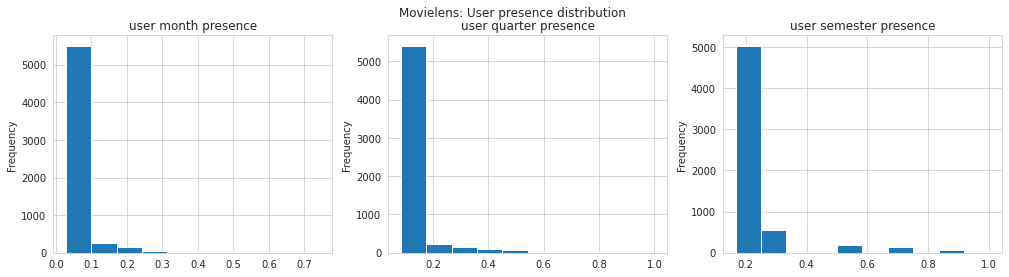

In [68]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name='Movielens')

How many examples are there per quarter and semester?

In [78]:
def plot_interactions_per_qns(user_interactions, date_range, dataset_name=None, type_of_range='quarter'):
    dates = [datetime.strftime( d[0], '%Y-%m' ) for d in date_range] + [datetime.strftime( date_range[-1][1]+timedelta(days=1), '%Y-%m' )]
    values = user_interactions.sum()
    values = values.reset_index()
    values.columns = ['date', 'count']
    values['date'] = dates
    fig, ax = plt.subplots(figsize=(6,10))
    fig = sns.barplot(x='count', y='date', data=values, color='blue', ax=ax )
    if dataset_name:
        plt.title(f'{dataset_name}: Interactions per {type_of_range}')
        plt.savefig(f'images/user_bucket_analysis/{dataset_name}_interactions_quarter.png')

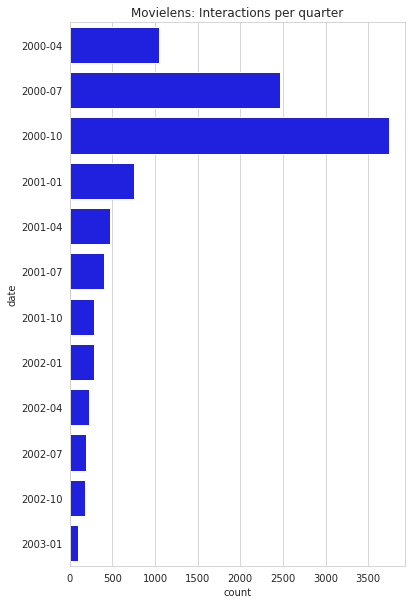

In [70]:
plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name='Movielens', type_of_range='quarter')

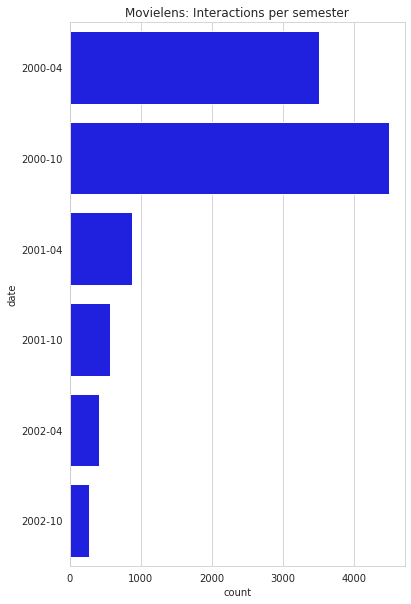

In [71]:
plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name='Movielens', type_of_range='semester')

In [72]:
# defining threshold
frequency_threshold = 0.8

# getting frequent users per month
frequent_users_month = user_presence_df[user_presence_df['month_%']>=frequency_threshold ]['UserID'].values
# percentage of users that are *frequent in months
print(
f'''{len(frequent_users_month)} users \
of {user_presence_df['UserID'].nunique()} \
({round( 100*len(frequent_users_month) / data['UserID'].nunique(), 3)}%) occurr in {frequency_threshold*100}% or more months (of {user_month_interactions["date"].nunique()}).'''
)

# getting frequent users per quarter
frequent_users_trimestre = user_presence_df[user_presence_df['trimestre_%']>=frequency_threshold ]['UserID'].values
# percentage of users that are *frequent in quarters
print(
f'''{len(frequent_users_trimestre)} users \
of {user_presence_df['UserID'].nunique()} \
({round( 100*len( frequent_users_trimestre ) / data["UserID"].nunique(), 3)}%) occurr in {frequency_threshold*100}% or more quarters (of {len( trimestres) +1}).'''
)

# getting frequent users per semester
frequent_users_semestre = user_presence_df[user_presence_df['semestre_%']>=frequency_threshold ]['UserID'].values
# percentage of users that are *frequent in semesters
print(
f'''{len(frequent_users_semestre)} users \
of {user_presence_df['UserID'].nunique()} \
({round( 100*len( frequent_users_semestre ) / data["UserID"].nunique(), 3)}%) occurr in {frequency_threshold*100}% or more semesters (of {len( semestres) +1}).'''
)

0 users of 6014 (0.0%) occurr in 80.0% or more months (of 35).
9 users of 6014 (0.15%) occurr in 80.0% or more quarters (of 12).
93 users of 6014 (1.546%) occurr in 80.0% or more semesters (of 6).


In median terms, how many times FREQUENT users appear in each quarter, and semester?

In [81]:
user_trimestre_interactions.loc[frequent_users_trimestre].median(axis=0)

0     0.0
1     0.0
2     2.0
3     2.0
4     2.0
5     2.0
6     2.0
7     2.0
8     3.0
9     3.0
10    2.0
11    1.0
dtype: float64

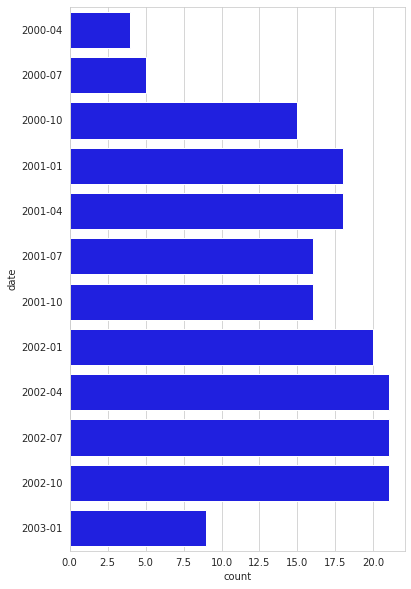

In [79]:
plot_interactions_per_qns(user_interactions=user_trimestre_interactions.loc[frequent_users_trimestre],
    date_range=trimestres)

In [82]:
user_semestre_interactions.loc[frequent_users_semestre].median(axis=0)

0    1.0
1    2.0
2    2.0
3    2.0
4    2.0
5    1.0
dtype: float64

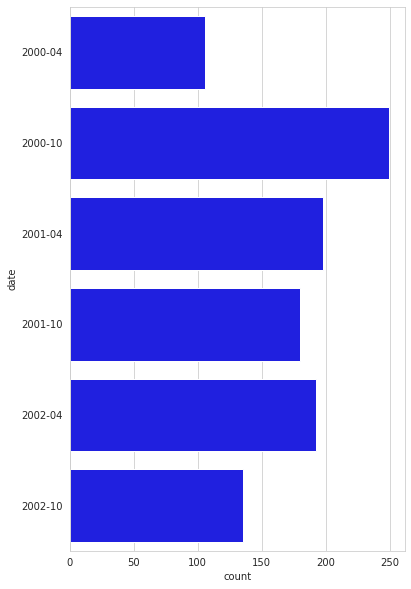

In [80]:
plot_interactions_per_qns(user_interactions=user_semestre_interactions.loc[frequent_users_semestre], date_range=semestres, type_of_range='semester')

In [83]:
# these are the users that should be used in holdouts, and only their last interactions
# BUT, there are users that do not appear in some intervals, and some have only one interaction
user_trimestre_interactions
user_semestre_interactions;

In [13]:
num_factors = 160
num_iter = 8
learn_rate = 0.1
regularization = 0.4
num_nodes = 8

In [14]:
# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
# stream = ImplicitData(data['UserID'].to_list(), data['ItemID'].to_list())
stream = ImplicitData(data['UserID'], data['ItemID'])

empty_stream = ImplicitData([], [])

In [15]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [16]:
# criamos instancia de EvaluateAndStore para criar holdouts com o método EvaluateAndStore
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_movielens = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics=["Recall@N"], N_recommendations=20, seed=42)

In [17]:
%%time
# interações de 0 a 100 são usadas para pre treino. 
# count define numero de interações a serem usadas.
# holdouts e checkpoints são 
# store_only - somente guarda holdouts, não faz avaliação prequencial.
# default_user - Somente usado quando store_only = False durante avaliação prequencial.
_ = eval_movielens.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 1:40 min

25 stored in 3
25 used in training
25 used in training
25 used in training
25 used in training
25 used in training
25 used in training
25 used in training
25 used in training
25 used in training
24 stored in 3
25 used in training
24 used in training
24 used in training
25 used in training
24 used in training
25 used in training
25 used in training
24 used in training
25 used in training
24 used in training
25 used in training
25 used in training
25 used in training
25 used in training
25 stored in 3
25 used in training
25 used in training
25 used in training
25 stored in 3
24 used in training
24 used in training
24 stored in 3
24 used in training
24 stored in 3
24 used in training
24 used in training
25 used in training
25 used in training
24 used in training
24 used in training
24 used in training
24 used in training
24 used in training
24 used in training
22 used in training
22 stored in 3
22 used in training
22 stored in 3
24 stored in 3
22 used in training
24 used in training
22 us

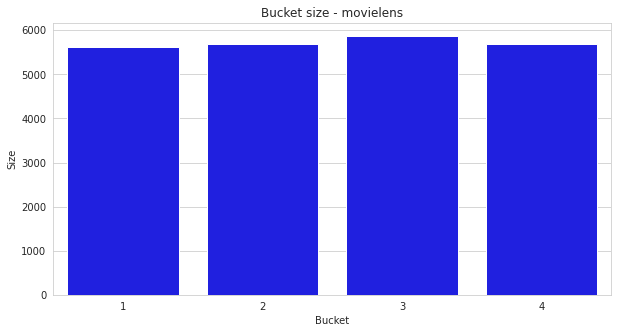

In [32]:
plot_bucket_size(eval_object=eval_movielens, dataset_name='movielens', filename='movielens_bucket_size.png')

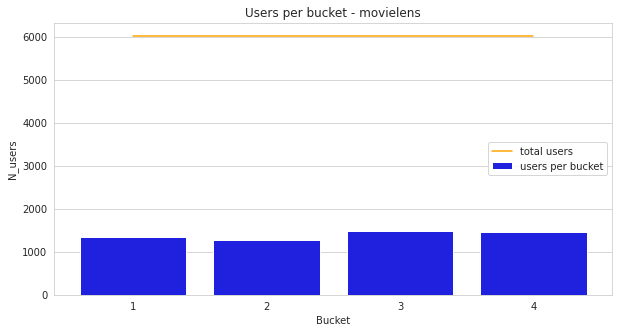

In [33]:
plot_n_users_per_bucket(eval_object=eval_movielens, dataset_name='movielens', filename='movielens_user_per_bucket.png')

In [57]:
movielens_ubm = get_bucket_map(eval_object=eval_movielens)
movielens_median_user_presence = median_user_presence_per_bucket(eval_object=eval_movielens, user_bucket_map=movielens_ubm)
print( movielens_median_user_presence )
store_user_presence(dataset_name='movielens', median_user_presence=movielens_median_user_presence)

In [55]:
joblib.dump(movielens_ubm, 'output/joblib_bucket_info_dump/movielens_ubm', compress=True)

['output/joblib_bucket_info_dump/movielens_ubm']

___

In [ ]:
data = pd.read_csv("../datasets/ymusic_gte90_6kusers.tsv","\t")
stream = ImplicitData(data['user_id'],data['item_id'])
empty_stream = ImplicitData([], [])

In [ ]:
num_factors = 200
num_iter = 9
learn_rate = 0.25
regularization = 0.45
num_nodes = 16

In [ ]:
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_ymusic = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics = ["Recall@N"], N_recommendations=20, seed=42)

In [ ]:
_=eval_ymusic.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 42 min

In [ ]:
joblib.dump(eval_ymusic, 'output/joblib_bucket_info_dump/eval_ymusic', compress=True)

___
### Lastfm

In [ ]:
# importa dataset 'palco playlists'
data = pd.read_csv("../datasets/lastfm_50u.tsv","\t")

# transforma interações em objeto que contem mappings usuário-itens e item-usuários, contém também métodos de suporte.
# recebe listas
stream = ImplicitData(data['user_id'], data['item_id'])

empty_stream = ImplicitData([], [])

In [ ]:
num_factors = 160
num_iter = 4
learn_rate = 0.5
regularization = 0.4
num_nodes = 8

In [ ]:
# O modelo não pode conter o stream, deve ser iniciado com uma lista vazia
# Se o stream for passado, ao excluir itens conhecidos o recall é sempre 0. Ao permitir a recomendação de itens já vistos, o recall não é 0.
model = ISGD(empty_stream, num_factors, num_iter, learn_rate = learn_rate, u_regularization = regularization, i_regularization = regularization, random_seed = 10)

In [ ]:
n_holdouts = int( data.shape[0]/n_iter_bucket )
eval_lastfm = EvaluateAndStore(model=model, data=stream, n_holdouts=n_holdouts, metrics = ["Recall@N"], N_recommendations=20, seed=42)

In [ ]:
_=eval_lastfm.EvaluateAndStore(start_eval=0, count=stream.size, store_only=True) # 441 min

In [ ]:
joblib.dump(eval_lastfm, 'output/joblib_bucket_info_dump/eval_lastfm', compress=True)

# Evaluation

In [ ]:
# def plot_n_users_per_bucket(eval_object:EvaluateAndStore, dataset_name:str, filename:str=None):
#     n_users = len( eval_object.data.userset )
#     n_users_bucket = pd.Series( [len( bucket.userset ) for bucket in eval_object.holdouts] )
#     n_users_bucket = n_users_bucket.reset_index()
#     n_users_bucket.columns = ['Bucket', 'N_users']
#     n_users_bucket['Bucket'] = n_users_bucket['Bucket']+1
#     plt.figure(figsize=(10,5))
#     sns.barplot(x='Bucket', y='N_users', data=n_users_bucket, color='b', label='users per bucket')
#     sns.lineplot(data=np.repeat(n_users, n_users_bucket.shape[0]), label='total users', color='orange')
#     plt.title(f'Users per bucket - {dataset_name}');
#     if filename:
#         plt.savefig(f'images/user_bucket_analysis/{filename}')

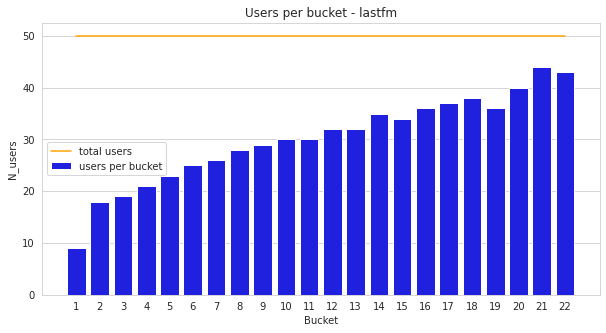

14.0

In [97]:
[bucket.userset for bucket in eval_lastfm.holdouts]

[array(['user_000174', 'user_000337', 'user_000407', 'user_000707',
        'user_000709', 'user_000751', 'user_000957', 'user_000984',
        'user_000986'], dtype='<U11'),
 array(['user_000019', 'user_000033', 'user_000174', 'user_000249',
        'user_000262', 'user_000267', 'user_000337', 'user_000390',
        'user_000407', 'user_000707', 'user_000709', 'user_000751',
        'user_000807', 'user_000882', 'user_000912', 'user_000957',
        'user_000984', 'user_000986'], dtype='<U11'),
 array(['user_000019', 'user_000033', 'user_000174', 'user_000249',
        'user_000262', 'user_000337', 'user_000374', 'user_000390',
        'user_000407', 'user_000707', 'user_000709', 'user_000751',
        'user_000767', 'user_000807', 'user_000882', 'user_000912',
        'user_000957', 'user_000984', 'user_000986'], dtype='<U11'),
 array(['user_000019', 'user_000033', 'user_000174', 'user_000249',
        'user_000262', 'user_000267', 'user_000330', 'user_000337',
        'user_000374',

In [43]:
plt.figure(figsize=(10,5))
sns.barplot(x='Bucket', y='N_users', data=n_users_bucket, color='b', label='users per bucket')
sns.lineplot(data=np.repeat(n_users, n_users_bucket.shape[0]), label='total users', color='orange');

3784